In [1]:
import os
import sys
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches
sys.path.append("/projects/b1198/epifluidlab/ravi/0130/headneck/scripts")
from loaders import HNSCCFeatureHandler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import balanced_accuracy_score, roc_curve, auc, roc_auc_score, confusion_matrix


METADATA_PATH = "/projects/b1198/epifluidlab/ravi/0130/headneck/metadata/RAW_HNSCC_METADATA.csv"
VALID_IDS_PATH = "/projects/b1198/epifluidlab/ravi/0130/headneck/notebooks/lists/valid_ids.txt"

# Loading the coverage feature. (cov)
cov = HNSCCFeatureHandler(METADATA_PATH, VALID_IDS_PATH)
_ = cov.load_feature_to_dataframe("/projects/b1198/epifluidlab/ravi/0130/headneck/data/hg38_frag_filtered/*.hg38.frag.delfi.bed", 1, 11)
_ = cov.normalize_total_sum()
_ = cov.normalize_zscore()
_ = cov.merge_feature_metadata()
_ = cov.batch_correct()

# Loading the DELFI feature. (delfi)
delfi = HNSCCFeatureHandler(METADATA_PATH, VALID_IDS_PATH)
_ = delfi.load_feature_to_dataframe("/projects/b1198/epifluidlab/ravi/0130/headneck/data/hg38_frag_filtered/*.hg38.frag.delfi.bed", 1, 12)
_ = delfi.normalize_zscore()
_ = delfi.merge_feature_metadata()
_ = delfi.batch_correct()

# Loading the MDS feature. (mds)
mds = HNSCCFeatureHandler(METADATA_PATH, VALID_IDS_PATH)
_ = mds.load_feature_to_dataframe("/projects/b1198/epifluidlab/ravi/0130/headneck/data/hg38_frag_filtered/*.hg38.frag.interval_mds.tsv", 0, 4)
_ = mds.normalize_zscore()
_ = mds.merge_feature_metadata()
_ = mds.batch_correct()

# Loading the fragment length feature. (fraglen)
fraglen = HNSCCFeatureHandler(METADATA_PATH, VALID_IDS_PATH)
_ = fraglen.load_feature_to_dataframe("/projects/b1198/epifluidlab/ravi/0130/headneck/data/hg38_frag_filtered/*.hg38.frag.frag_length_intervals.bed", 1, 4)
_ = fraglen.normalize_zscore()
_ = fraglen.merge_feature_metadata()
_ = fraglen.batch_correct()

# Loading the ichorCNA feature. (cna)
cna = HNSCCFeatureHandler(METADATA_PATH, VALID_IDS_PATH)
_ = cna.load_feature_to_dataframe("/projects/b1198/epifluidlab/ravi/0130/headneck/data/ichorCNA/expanded/*.cna.seg", 1, 5, na_value="NA")
_ = cna.normalize_zscore()
_ = cna.merge_feature_metadata()
_ = cna.batch_correct()

# Function to get the training and testing data.
def prepare_train_test(hc_data):
    train_ids = list(hc_data.institute1_ids) + list(hc_data.institute2_ids) + list(hc_data.institute3_ids) + list(hc_data.institute4_ids)
    test_ids = list(hc_data.institute5_ids) + list(hc_data.institute6_ids)

    # Training data
    final_patient_df_train = hc_data.get_raw_features(hc_data.get_subset(train_ids))
    final_patient_df_train_metadata = hc_data.get_metadata_col("Treatment Response", hc_data.get_subset(train_ids))
    final_patient_df_train = pd.concat([final_patient_df_train, final_patient_df_train_metadata], axis=1)

    # Test data
    final_patient_df_test = hc_data.get_raw_features(hc_data.get_subset(test_ids))
    final_patient_df_test_metadata = hc_data.get_metadata_col("Treatment Response", hc_data.get_subset(test_ids))
    final_patient_df_test = pd.concat([final_patient_df_test, final_patient_df_test_metadata], axis=1)

    return final_patient_df_train, final_patient_df_test.astype(str)

cov_train, cov_test = prepare_train_test(cov)
delfi_train, delfi_test = prepare_train_test(delfi)
mds_train, mds_test = prepare_train_test(mds)
fraglen_train, fraglen_test = prepare_train_test(fraglen)
cna_train, cna_test = prepare_train_test(cna)

# Models
models = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier()
]

# Hyperparameter grids
param_grids = {
    'RandomForestClassifier': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    },
    'GradientBoostingClassifier': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'AdaBoostClassifier': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0]
    }
}


                      Institute  Library_Prep_Date  cfDNA_Isolation_Date  \
Institute              1.000000          -0.465808              0.542575   
Library_Prep_Date     -0.465808           1.000000             -0.673446   
cfDNA_Isolation_Date   0.542575          -0.673446              1.000000   
Treatment_Response    -0.131130          -0.031933              0.290295   

                      Treatment_Response  
Institute                      -0.131130  
Library_Prep_Date              -0.031933  
cfDNA_Isolation_Date            0.290295  
Treatment_Response              1.000000  
                      Institute  Library_Prep_Date  cfDNA_Isolation_Date  \
Institute              1.000000          -0.465808              0.542575   
Library_Prep_Date     -0.465808           1.000000             -0.673446   
cfDNA_Isolation_Date   0.542575          -0.673446              1.000000   
Treatment_Response    -0.131130          -0.031933              0.290295   

                      T

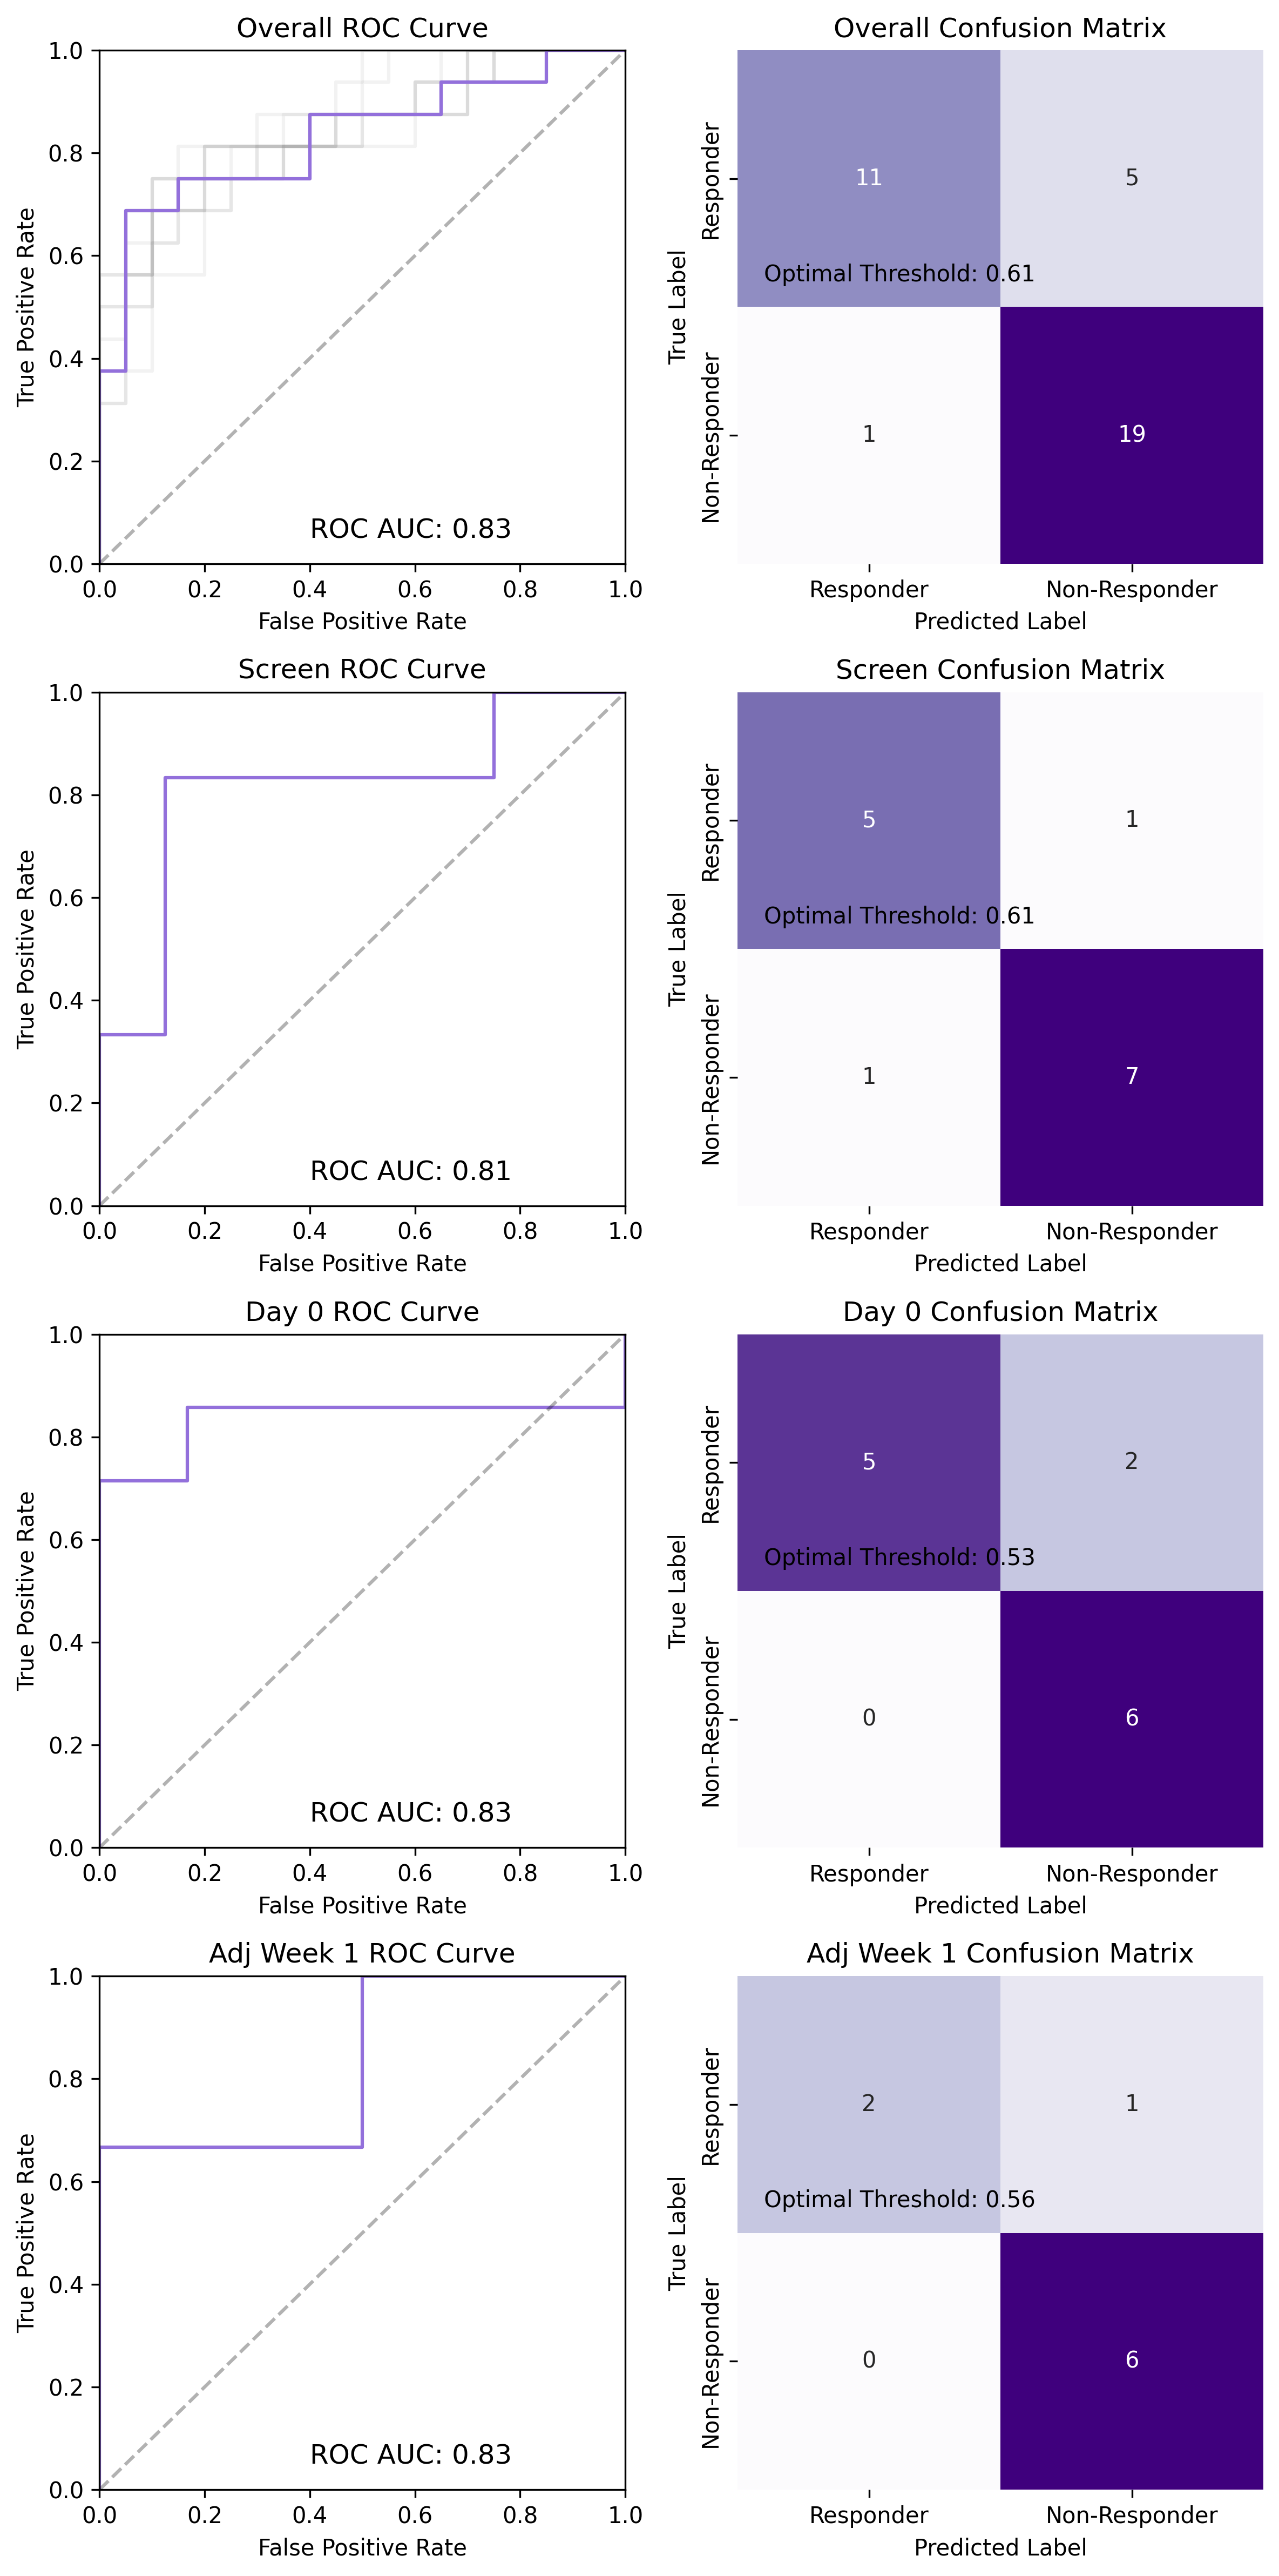

Best Overall Model: RandomForestClassifier(min_samples_split=10)
Top Features: ['chr10:72500000-73000000', 'chr11:102500000-103000000', 'chr11:103000000-103500000', 'chr12:118500000-119000000', 'chr12:88500000-89000000', 'chr16:10000000-10500000', 'chr16:52000000-52500000', 'chr16:59500000-60000000', 'chr16:61500000-62000000', 'chr1:27000000-27500000', 'chr20:42500000-43000000', 'chr22:28000000-28500000', 'chr4:141500000-142000000', 'chr4:174000000-174500000', 'chr5:35000000-35500000', 'chr5:5000000-5500000', 'chr5:5500000-6000000', 'chr7:79000000-79500000', 'chr17:13500000-14000000', 'chr5:100500000-101000000', 'chr5:157000000-157500000', 'chr12:64000000-64500000', 'chr10:58500000-59000000', 'chr1:236000000-236500000', 'chr2:14500000-15000000', 'chr5:52500000-53000000', 'chr5:7000000-7500000', 'chr14:78000000-78500000', 'chr16:7500000-8000000', 'chr4:155000000-155500000', 'chr6:25500000-26000000', 'chr6:28000000-28500000', 'chr17:17000000-17500000', 'chr2:19500000-20000000', 'chr6:765

In [2]:
cov_rfc_results, cov_rfc_model, cov_rfc_top_features, cov_rfc_preds_dictionary, cov_data = cov.train_test_model(models[0], param_grids['RandomForestClassifier'], cov_train, cov_test, cv_split=10, k=50)

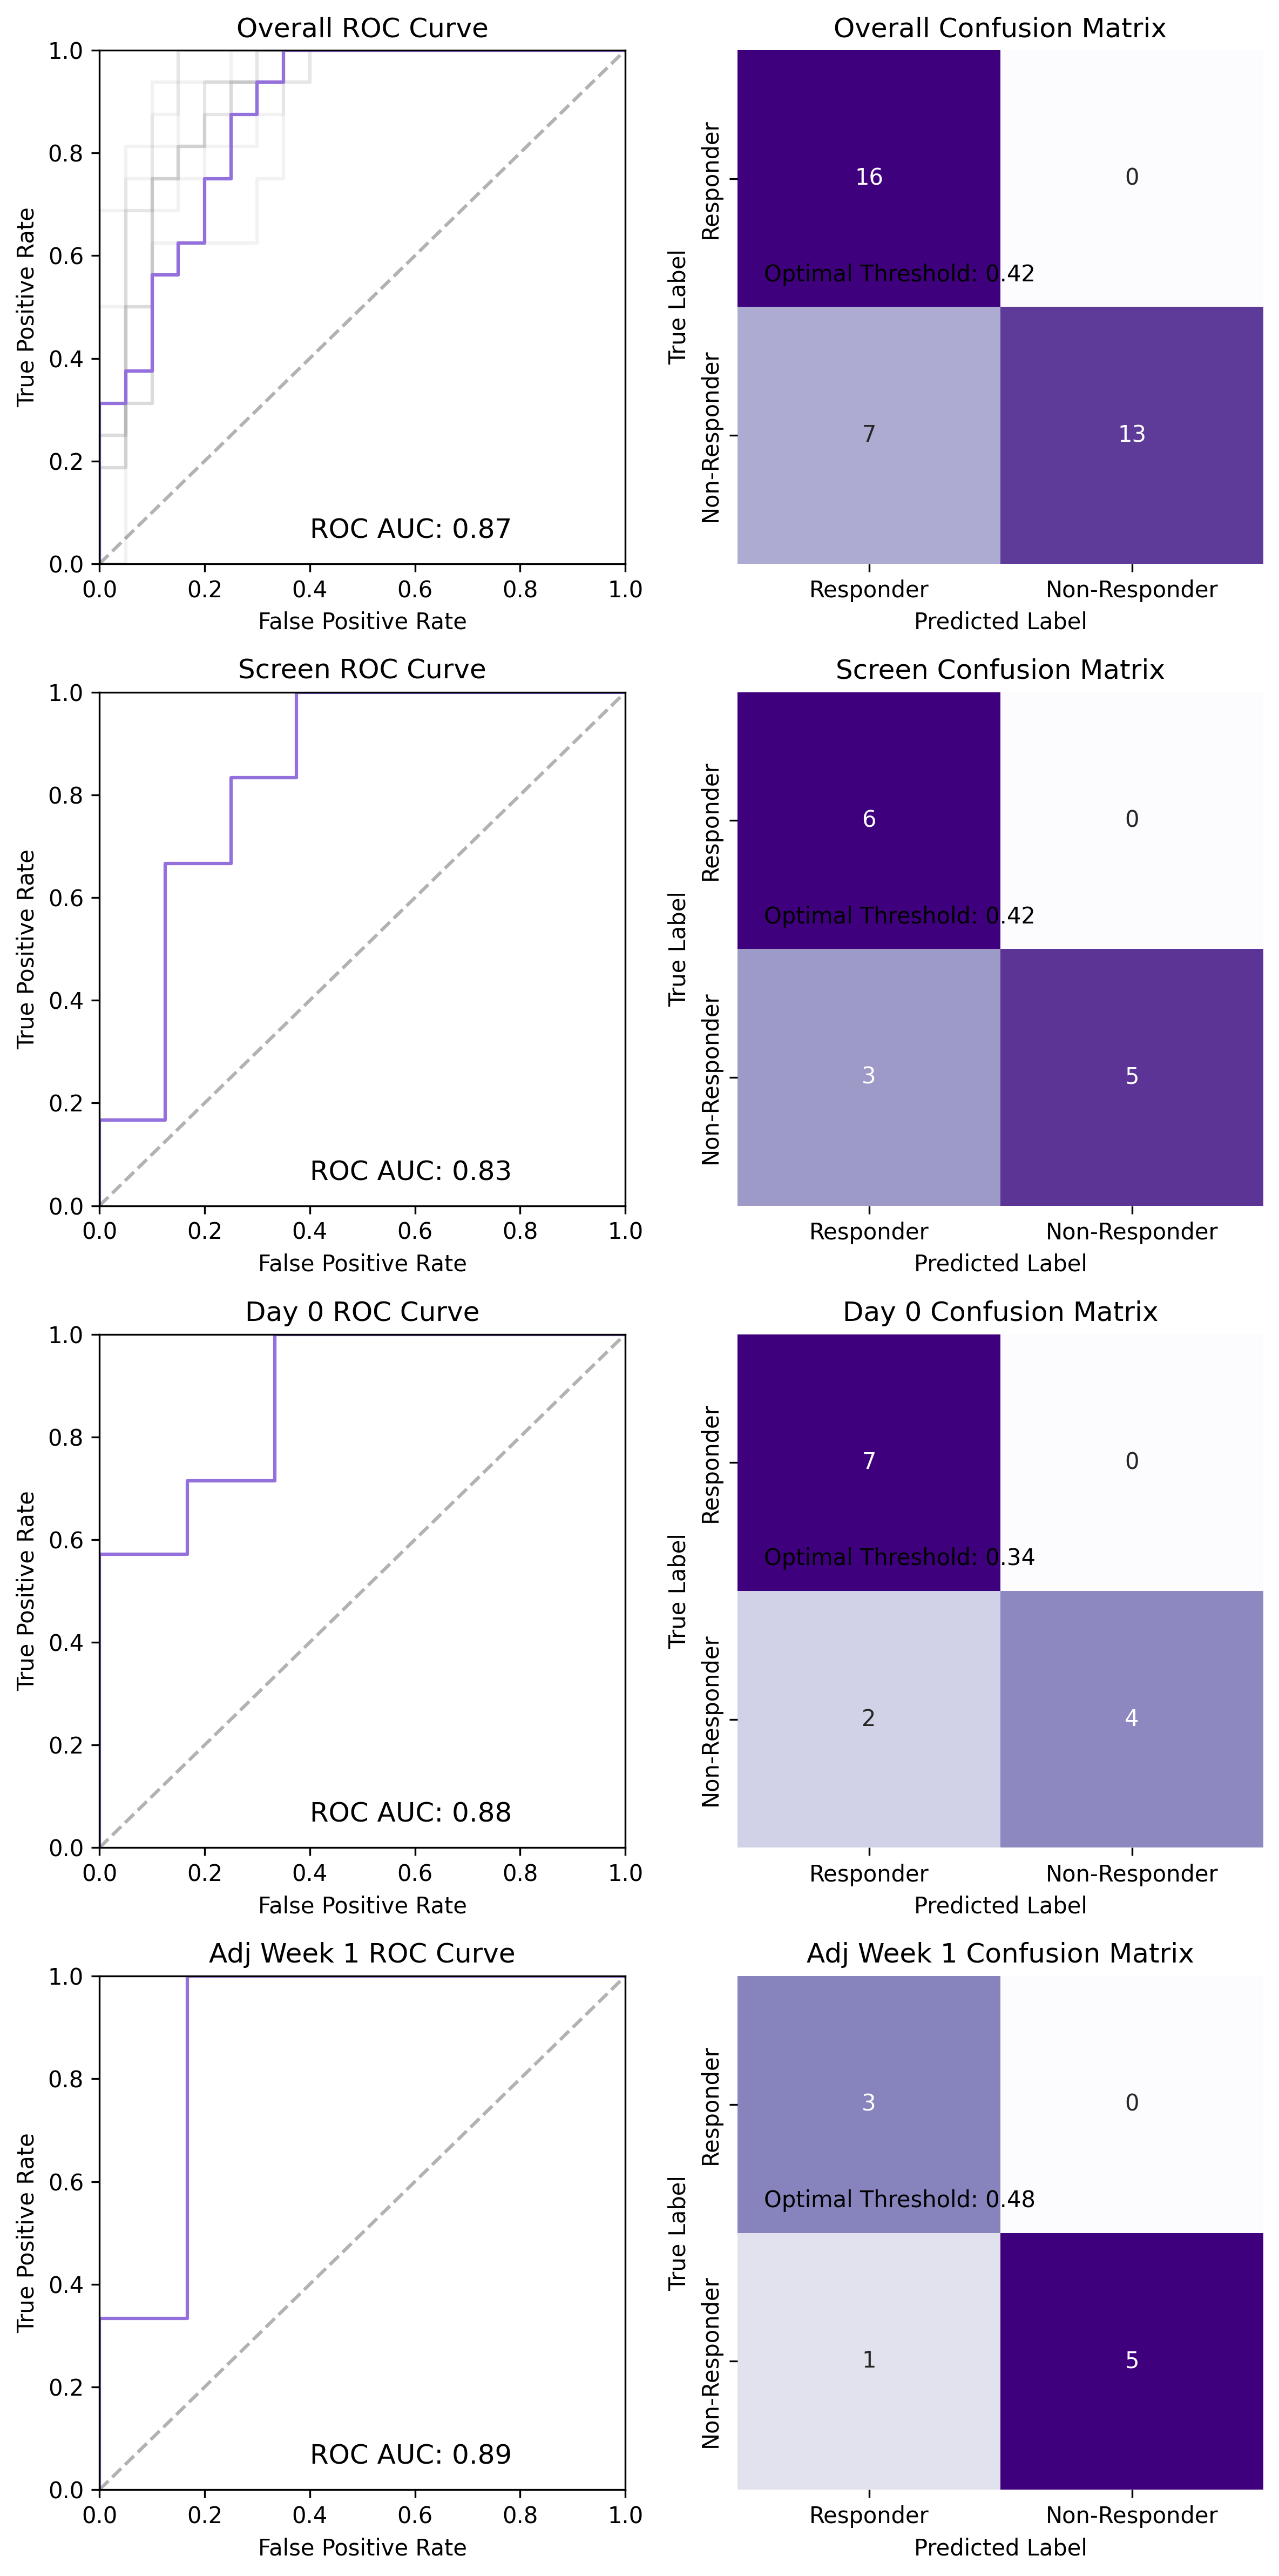

Best Overall Model: RandomForestClassifier(min_samples_leaf=2, n_estimators=50)
Top Features: ['chr11:104500000-105000000', 'chr16:10000000-10500000', 'chr16:77000000-77500000', 'chr1:2000000-2500000', 'chr2:109000000-109500000', 'chr2:166500000-167000000', 'chr4:135000000-135500000', 'chr4:178000000-178500000', 'chr4:57500000-58000000', 'chr5:126000000-126500000', 'chr6:133500000-134000000', 'chr6:46000000-46500000', 'chr8:77500000-78000000', 'chr8:79500000-80000000', 'chr8:87500000-88000000', 'chr9:101500000-102000000', 'chr12:48000000-48500000', 'chr2:50500000-51000000', 'chr5:136000000-136500000', 'chr5:51500000-52000000', 'chr6:36000000-36500000', 'chr11:103500000-104000000', 'chr2:172500000-173000000', 'chr3:5000000-5500000', 'chr3:50000000-50500000', 'chr6:39500000-40000000', 'chr6:44500000-45000000', 'chr6:46500000-47000000', 'chr5:32500000-33000000', 'chr18:9000000-9500000', 'chr1:55000000-55500000', 'chr4:173000000-173500000', 'chr13:100500000-101000000', 'chr16:19500000-2000

In [3]:
delfi_rfc_results, delfi_rfc_model, delfi_rfc_top_features, delfi_rfc_preds_dictionary, delfi_data = delfi.train_test_model(models[0], param_grids['RandomForestClassifier'], delfi_train, delfi_test, cv_split=10, k=50)

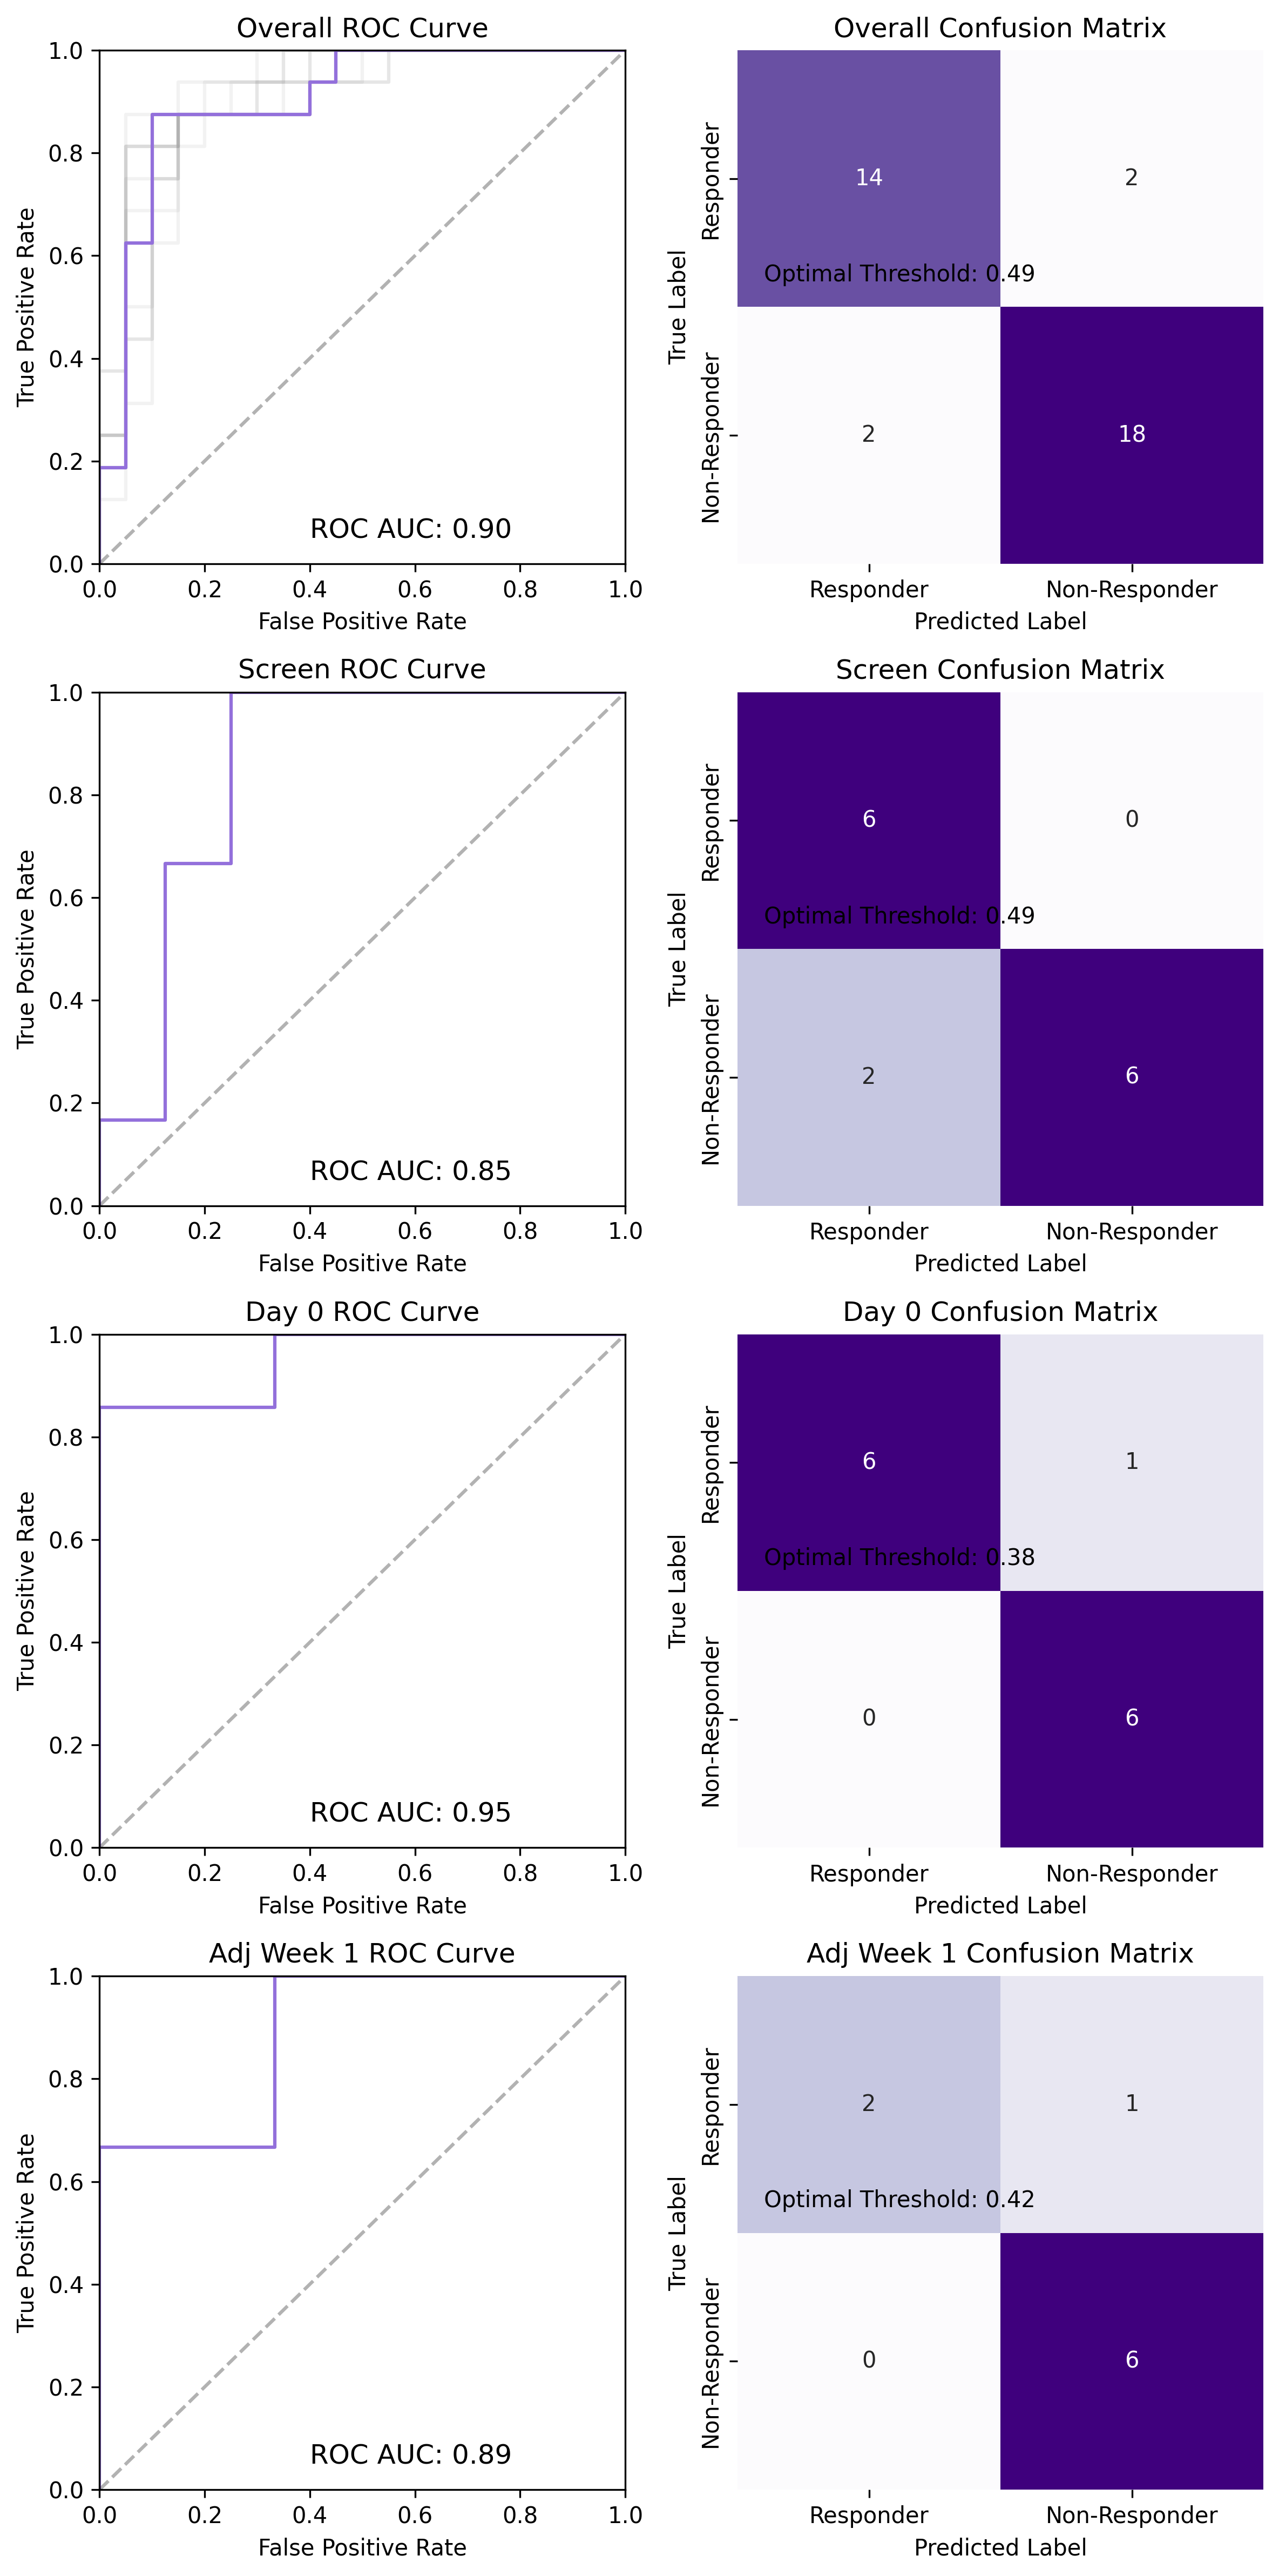

Best Overall Model: RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=50)
Top Features: ['chr14:95000000-95500000', 'chr15:89500000-90000000', 'chr18:31500000-32000000', 'chr1:199500000-200000000', 'chr1:22000000-22500000', 'chr21:34500000-35000000', 'chr2:154500000-155000000', 'chr2:188000000-188500000', 'chr2:20500000-21000000', 'chr3:11000000-11500000', 'chr3:133500000-134000000', 'chr3:51500000-52000000', 'chr5:25500000-26000000', 'chr5:91500000-92000000', 'chr6:104000000-104500000', 'chr6:76500000-77000000', 'chr7:108500000-109000000', 'chr9:11000000-11500000', 'chr9:115000000-115500000', 'chr4:85500000-86000000', 'chr7:151500000-152000000', 'chr8:104000000-104500000', 'chr8:121500000-122000000', 'chr9:73000000-73500000', 'chr12:7000000-7500000', 'chr2:198000000-198500000', 'chr2:56000000-56500000', 'chr3:128500000-129000000', 'chr6:50000000-50500000', 'chr20:33000000-33500000', 'chr12:109500000-

In [4]:
mds_rfc_results, mds_rfc_model, mds_rfc_top_features, mds_rfc_preds_dictionary, mds_data = mds.train_test_model(models[0], param_grids['RandomForestClassifier'], mds_train, mds_test, cv_split=10, k=50)

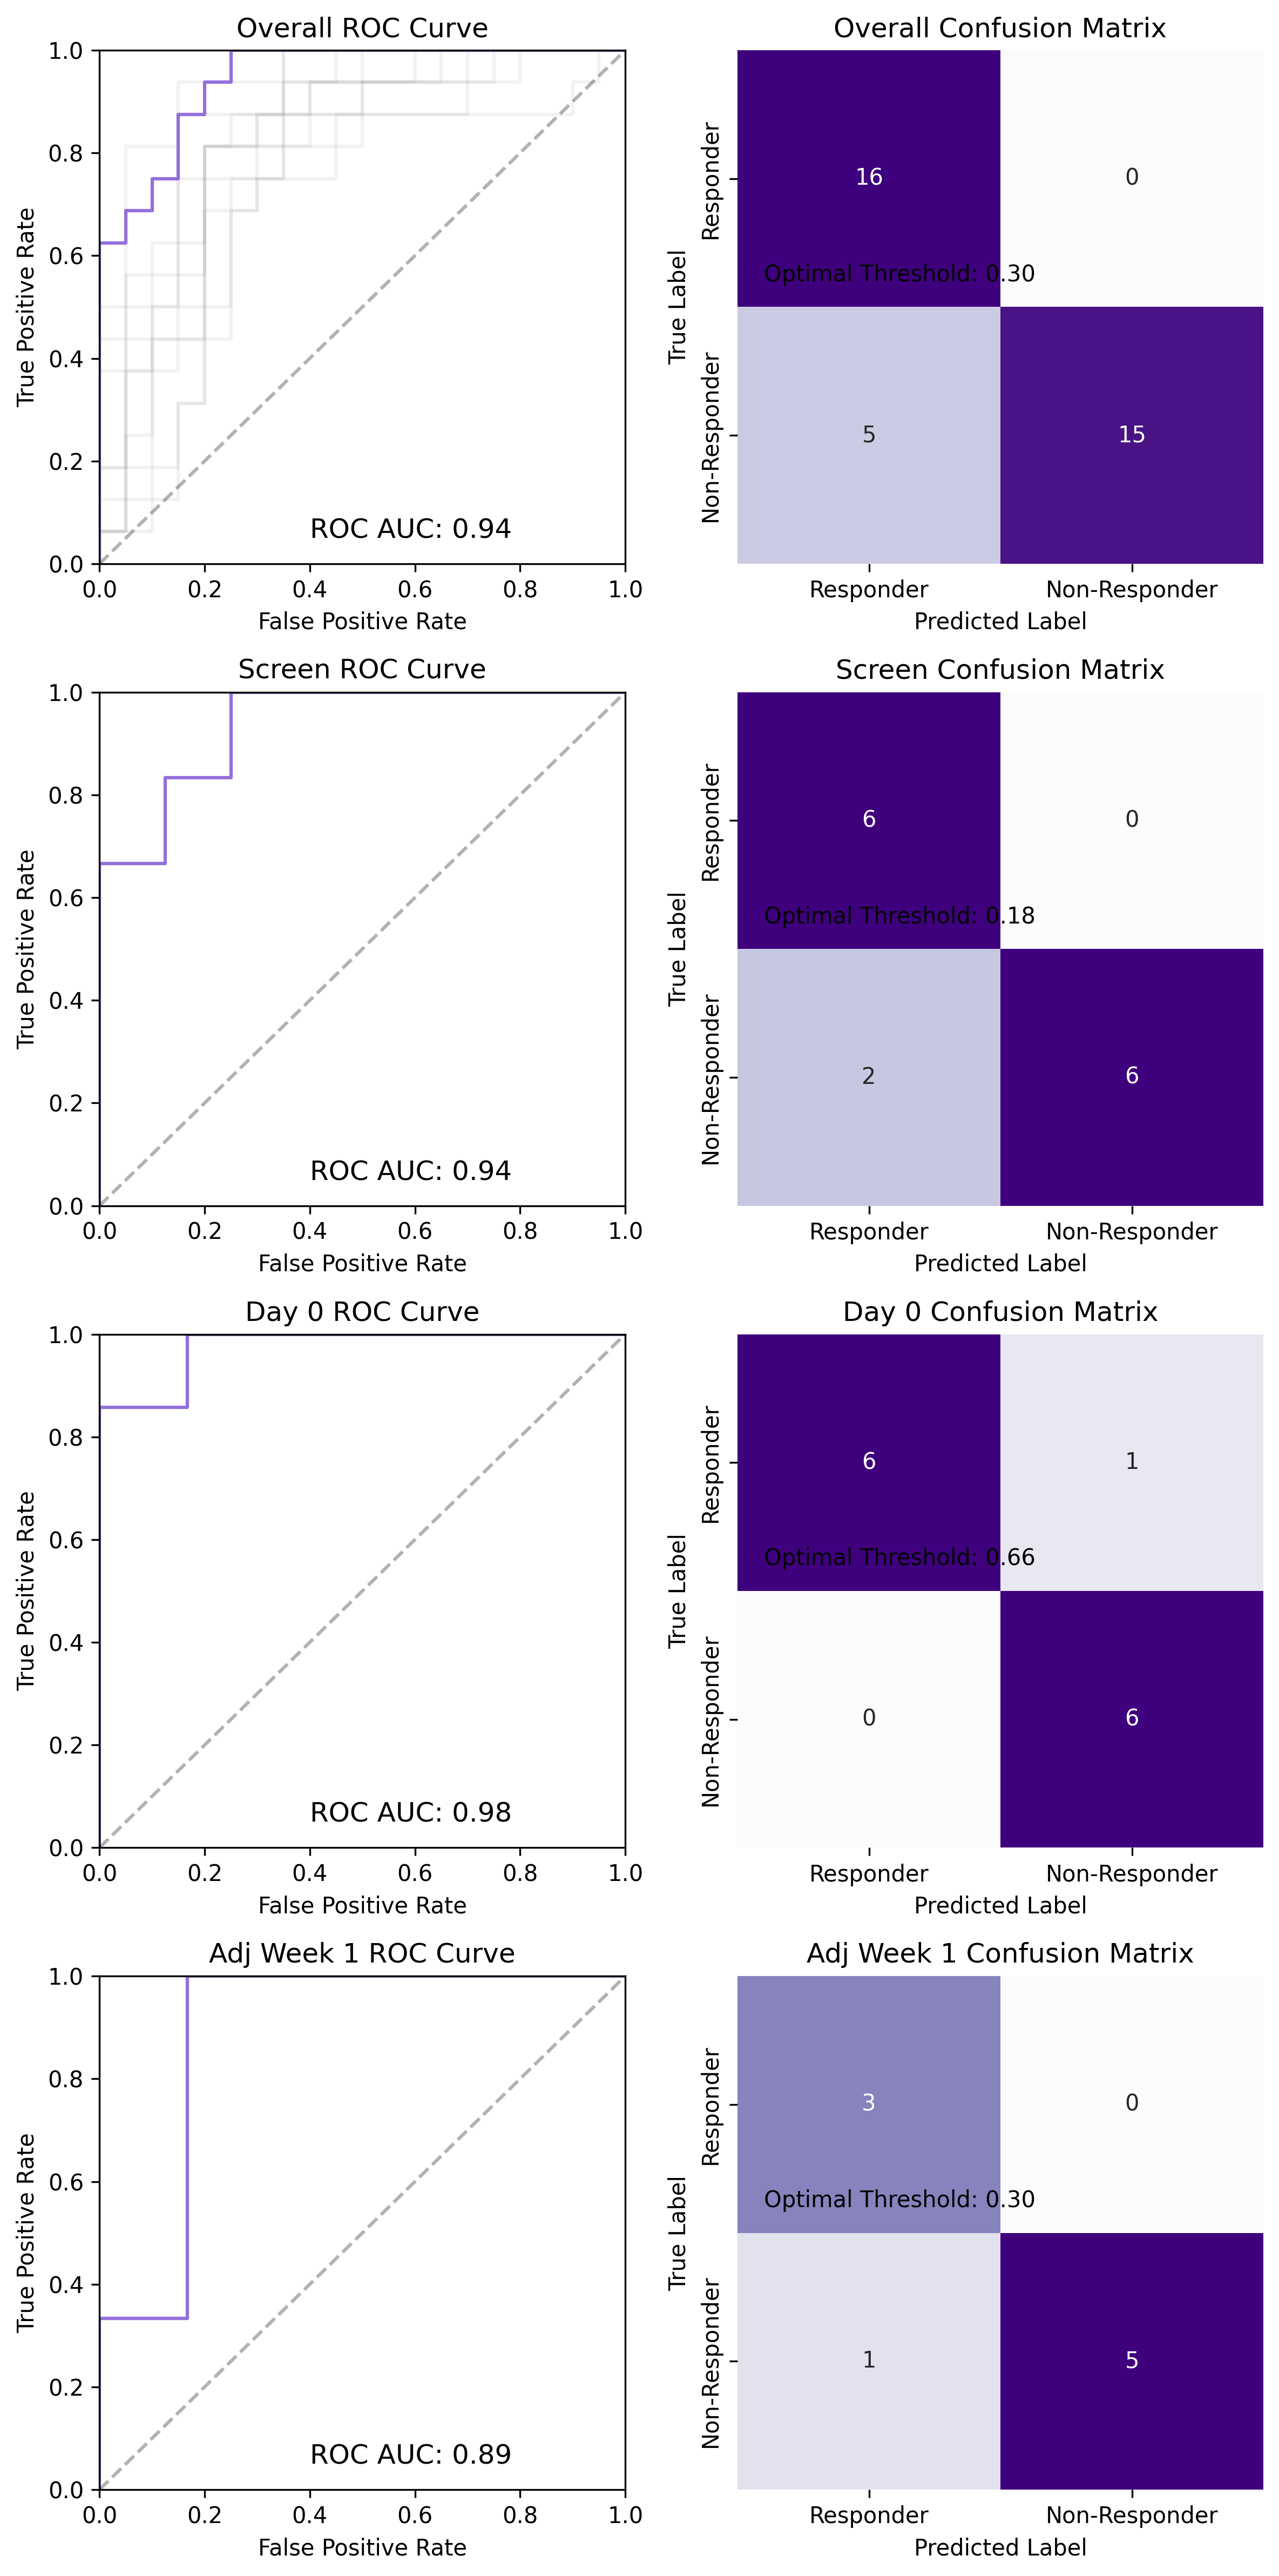

Best Overall Model: GradientBoostingClassifier(min_samples_split=5, n_estimators=50)
Top Features: ['chr10:56000000-56500000', 'chr12:48000000-48500000', 'chr12:84500000-85000000', 'chr16:1000000-1500000', 'chr17:80500000-81000000', 'chr1:190000000-190500000', 'chr1:22000000-22500000', 'chr1:222000000-222500000', 'chr2:140000000-140500000', 'chr3:85500000-86000000', 'chr4:72000000-72500000', 'chr5:107500000-108000000', 'chr5:112000000-112500000', 'chr7:79000000-79500000', 'chr10:132000000-132500000', 'chr12:132000000-132500000', 'chr20:32500000-33000000', 'chr11:102500000-103000000', 'chr15:68000000-68500000', 'chr19:27500000-28000000', 'chr14:76500000-77000000', 'chr18:71000000-71500000', 'chr14:32000000-32500000', 'chr19:33000000-33500000', 'chr1:2000000-2500000', 'chr1:7500000-8000000', 'chr2:164500000-165000000', 'chr2:225000000-225500000', 'chr4:3000000-3500000', 'chr5:142000000-142500000', 'chr6:131500000-132000000', 'chr8:71500000-72000000', 'chr9:134000000-134500000', 'chr11:24

In [5]:
fraglen_gbc_results, fraglen_gbc_model, fraglen_gbc_top_features, fraglen_gbc_preds_dictionary, fraglen_data = fraglen.train_test_model(models[1], param_grids['GradientBoostingClassifier'], fraglen_train, fraglen_test, cv_split=10, k=50)

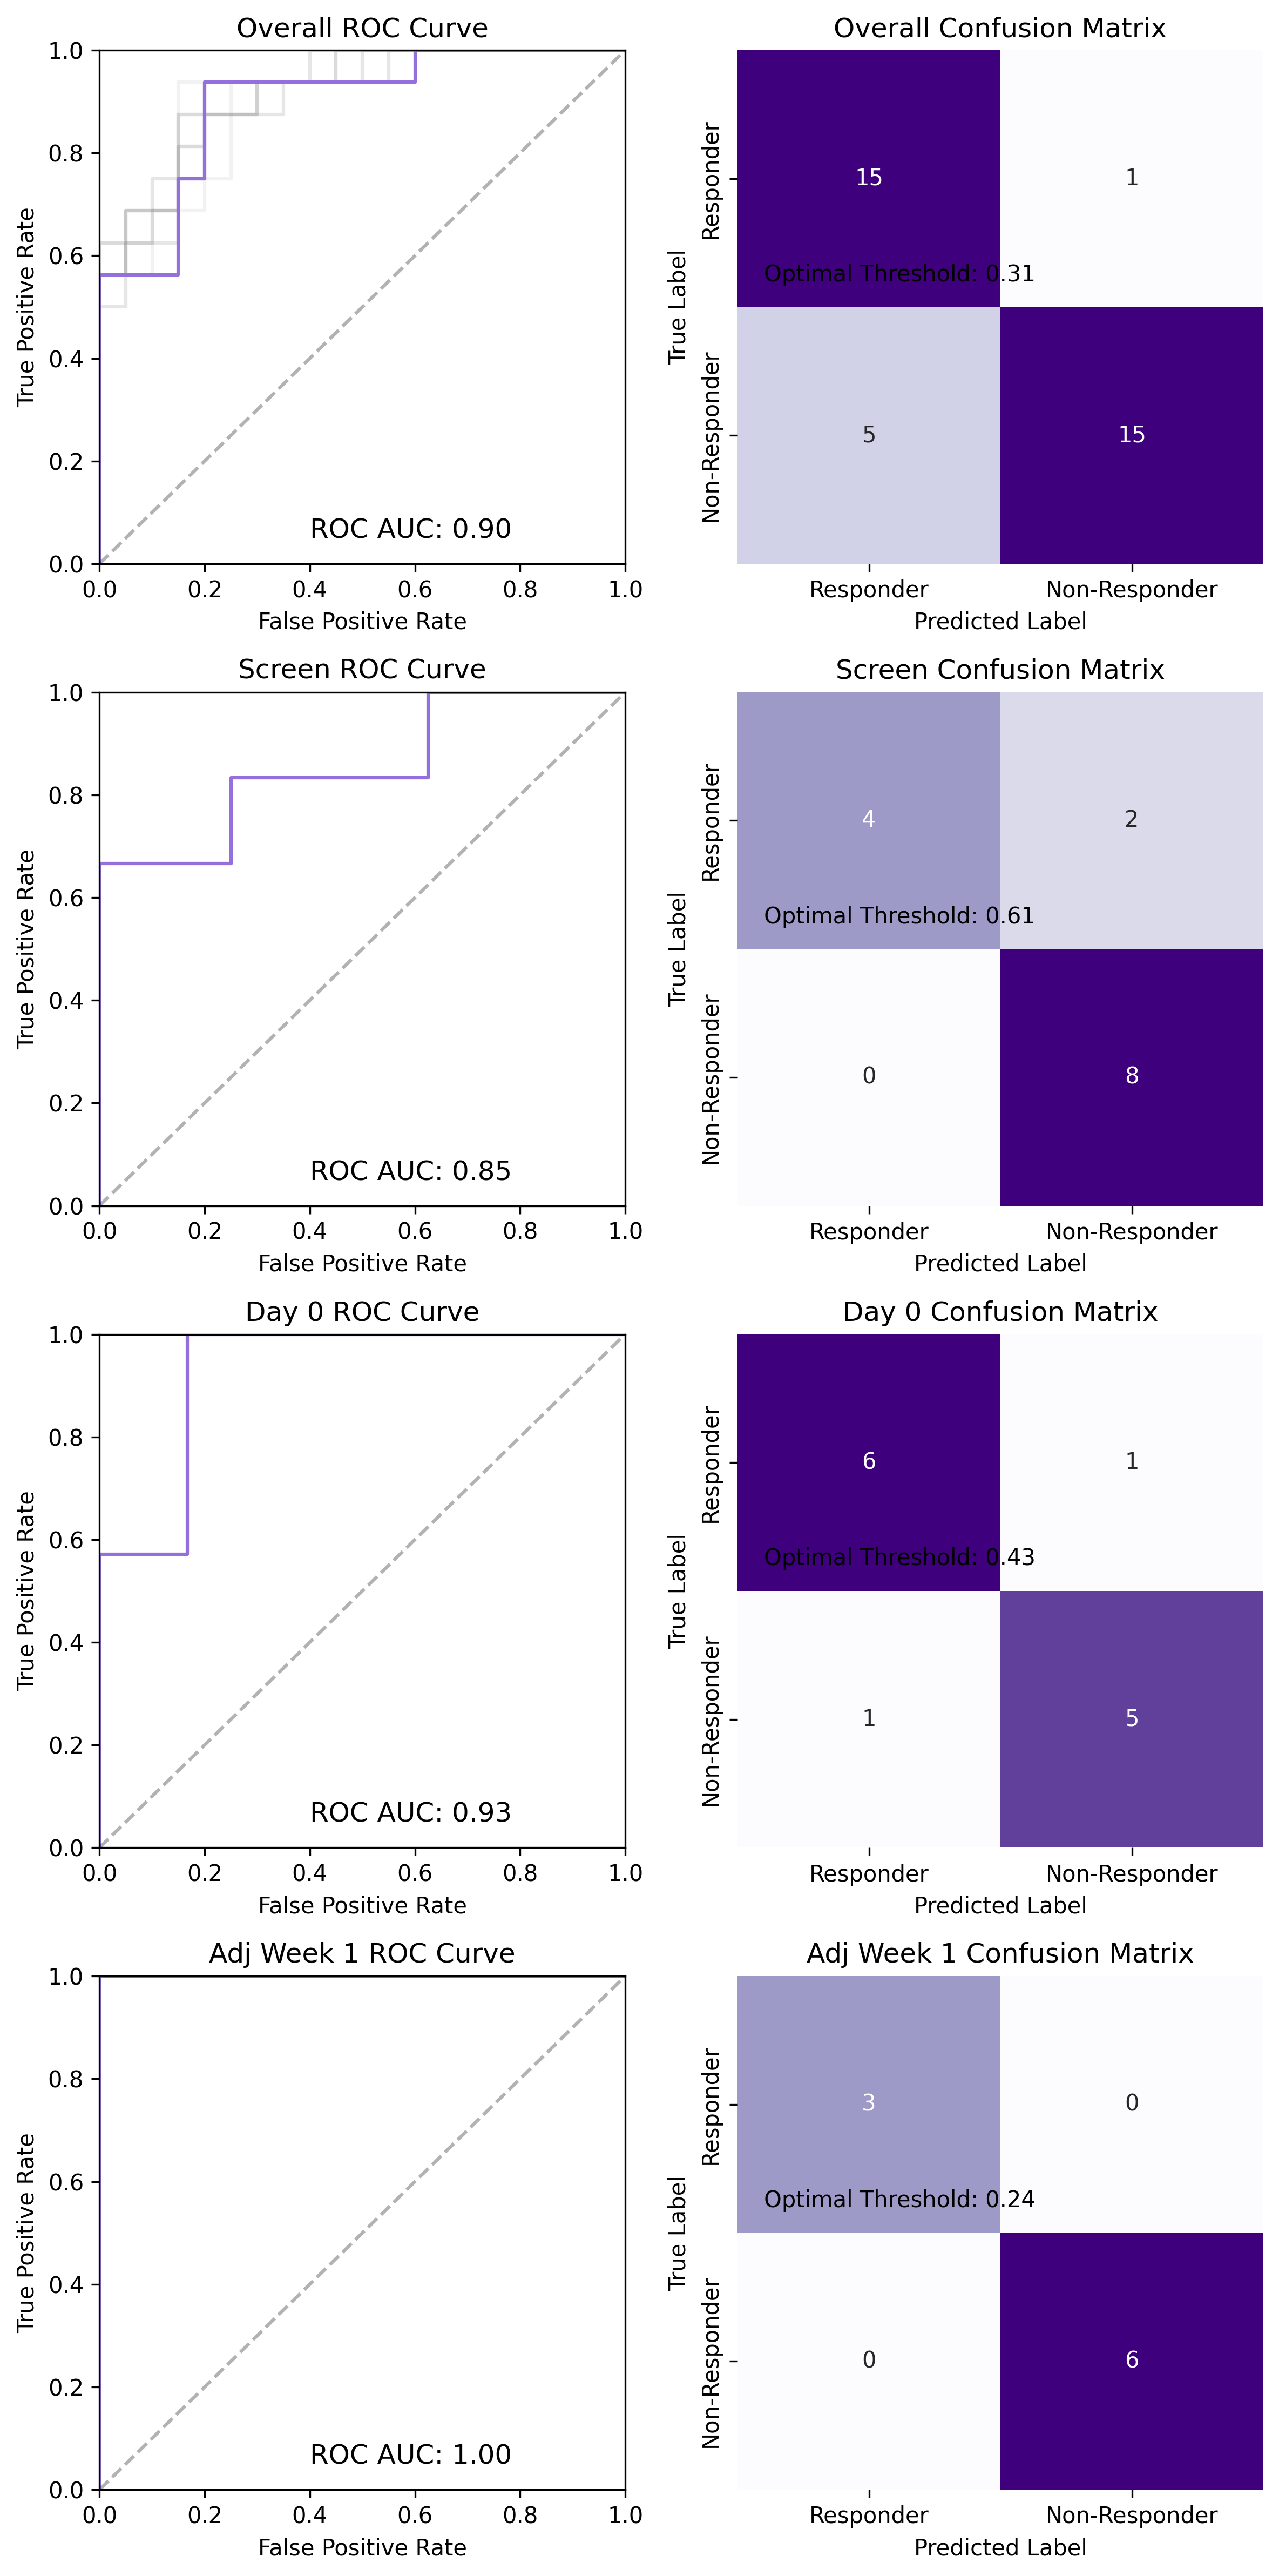

Best Overall Model: RandomForestClassifier(min_samples_split=10, n_estimators=50)
Top Features: ['chr10:104000001-104500000', 'chr10:2000001-2500000', 'chr11:103000001-103500000', 'chr14:62500001-63000000', 'chr16:52000001-52500000', 'chr1:27000001-27500000', 'chr20:42500001-43000000', 'chr2:3000001-3500000', 'chr2:6000001-6500000', 'chr2:80500001-81000000', 'chr5:136500001-137000000', 'chr5:5000001-5500000', 'chr6:168500001-169000000', 'chr6:76500001-77000000', 'chr7:132000001-132500000', 'chr7:68500001-69000000', 'chr7:71000001-71500000', 'chr9:117000001-117500000', 'chr11:41500001-42000000', 'chr16:7500001-8000000', 'chr18:28000001-28500000', 'chr20:19000001-19500000', 'chr4:174000001-174500000', 'chr5:167000001-167500000', 'chr2:14000001-14500000', 'chr7:53500001-54000000', 'chr2:209000001-209500000', 'chr2:52000001-52500000', 'chr3:64500001-65000000', 'chr6:13500001-14000000', 'chr12:128000001-128500000', 'chr2:80000001-80500000', 'chr5:90500001-91000000', 'chr12:114500001-1150000

In [6]:
cna_rfc_results, cna_rfc_model, cna_rfc_top_features, cna_rfc_preds_dictionary, cna_data = cna.train_test_model(models[0], param_grids['RandomForestClassifier'], cna_train, cna_test, cv_split=10, k=50)

In [18]:
combined_data = pd.DataFrame({
    'cov_data': cov_data['Predicted Treatment Probabilities'],
    'delfi_data': delfi_data['Predicted Treatment Probabilities'],
    'mds_data': mds_data['Predicted Treatment Probabilities'],
    'fraglen_data': fraglen_data['Predicted Treatment Probabilities'],
    'cna_data': cna_data['Predicted Treatment Probabilities'],
    'Treatment Response': cna_data['Treatment Response']
})

train_ids = list(cov.institute1_ids) + list(cov.institute2_ids) + list(cov.institute3_ids) + list(cov.institute4_ids)
test_ids = list(cov.institute5_ids) + list(cov.institute6_ids)

X = combined_data.drop(columns=['Treatment Response'])
y = combined_data['Treatment Response']

# Splitting the data based on train and test IDs
meta_train = combined_data[combined_data.index.isin(train_ids)]
meta_test = combined_data[combined_data.index.isin(test_ids)]

# Averaging the probabilities to get one metaprobability
#combined_data['Meta Probability'] = combined_data[['cov_data', 'delfi_data', 'mds_data', 'fraglen_data', 'cna_data']].mean(axis=1)

# Adding a new column for predicted treatment response
#combined_data['Predicted Treatment Response'] = combined_data[['cov_data', 'delfi_data', 'mds_data', 'fraglen_data', 'cna_data']].apply(lambda row: 'Responder' if (row > 0.48).sum() > 2.5 else 'Non-Responder', axis=1)


/home/myt8099/.conda/envs/bert/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=5. All the features will be returned.
  warnings.warn(
/home/myt8099/.conda/envs/bert/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=5. All the features will be returned.
  warnings.warn(
/home/myt8099/.conda/envs/bert/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=5. All the features will be returned.
  warnings.warn(
/home/myt8099/.conda/envs/bert/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=5. All the features will be returned.
  warnings.warn(
/home/myt8099/.conda/envs/bert/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10 is

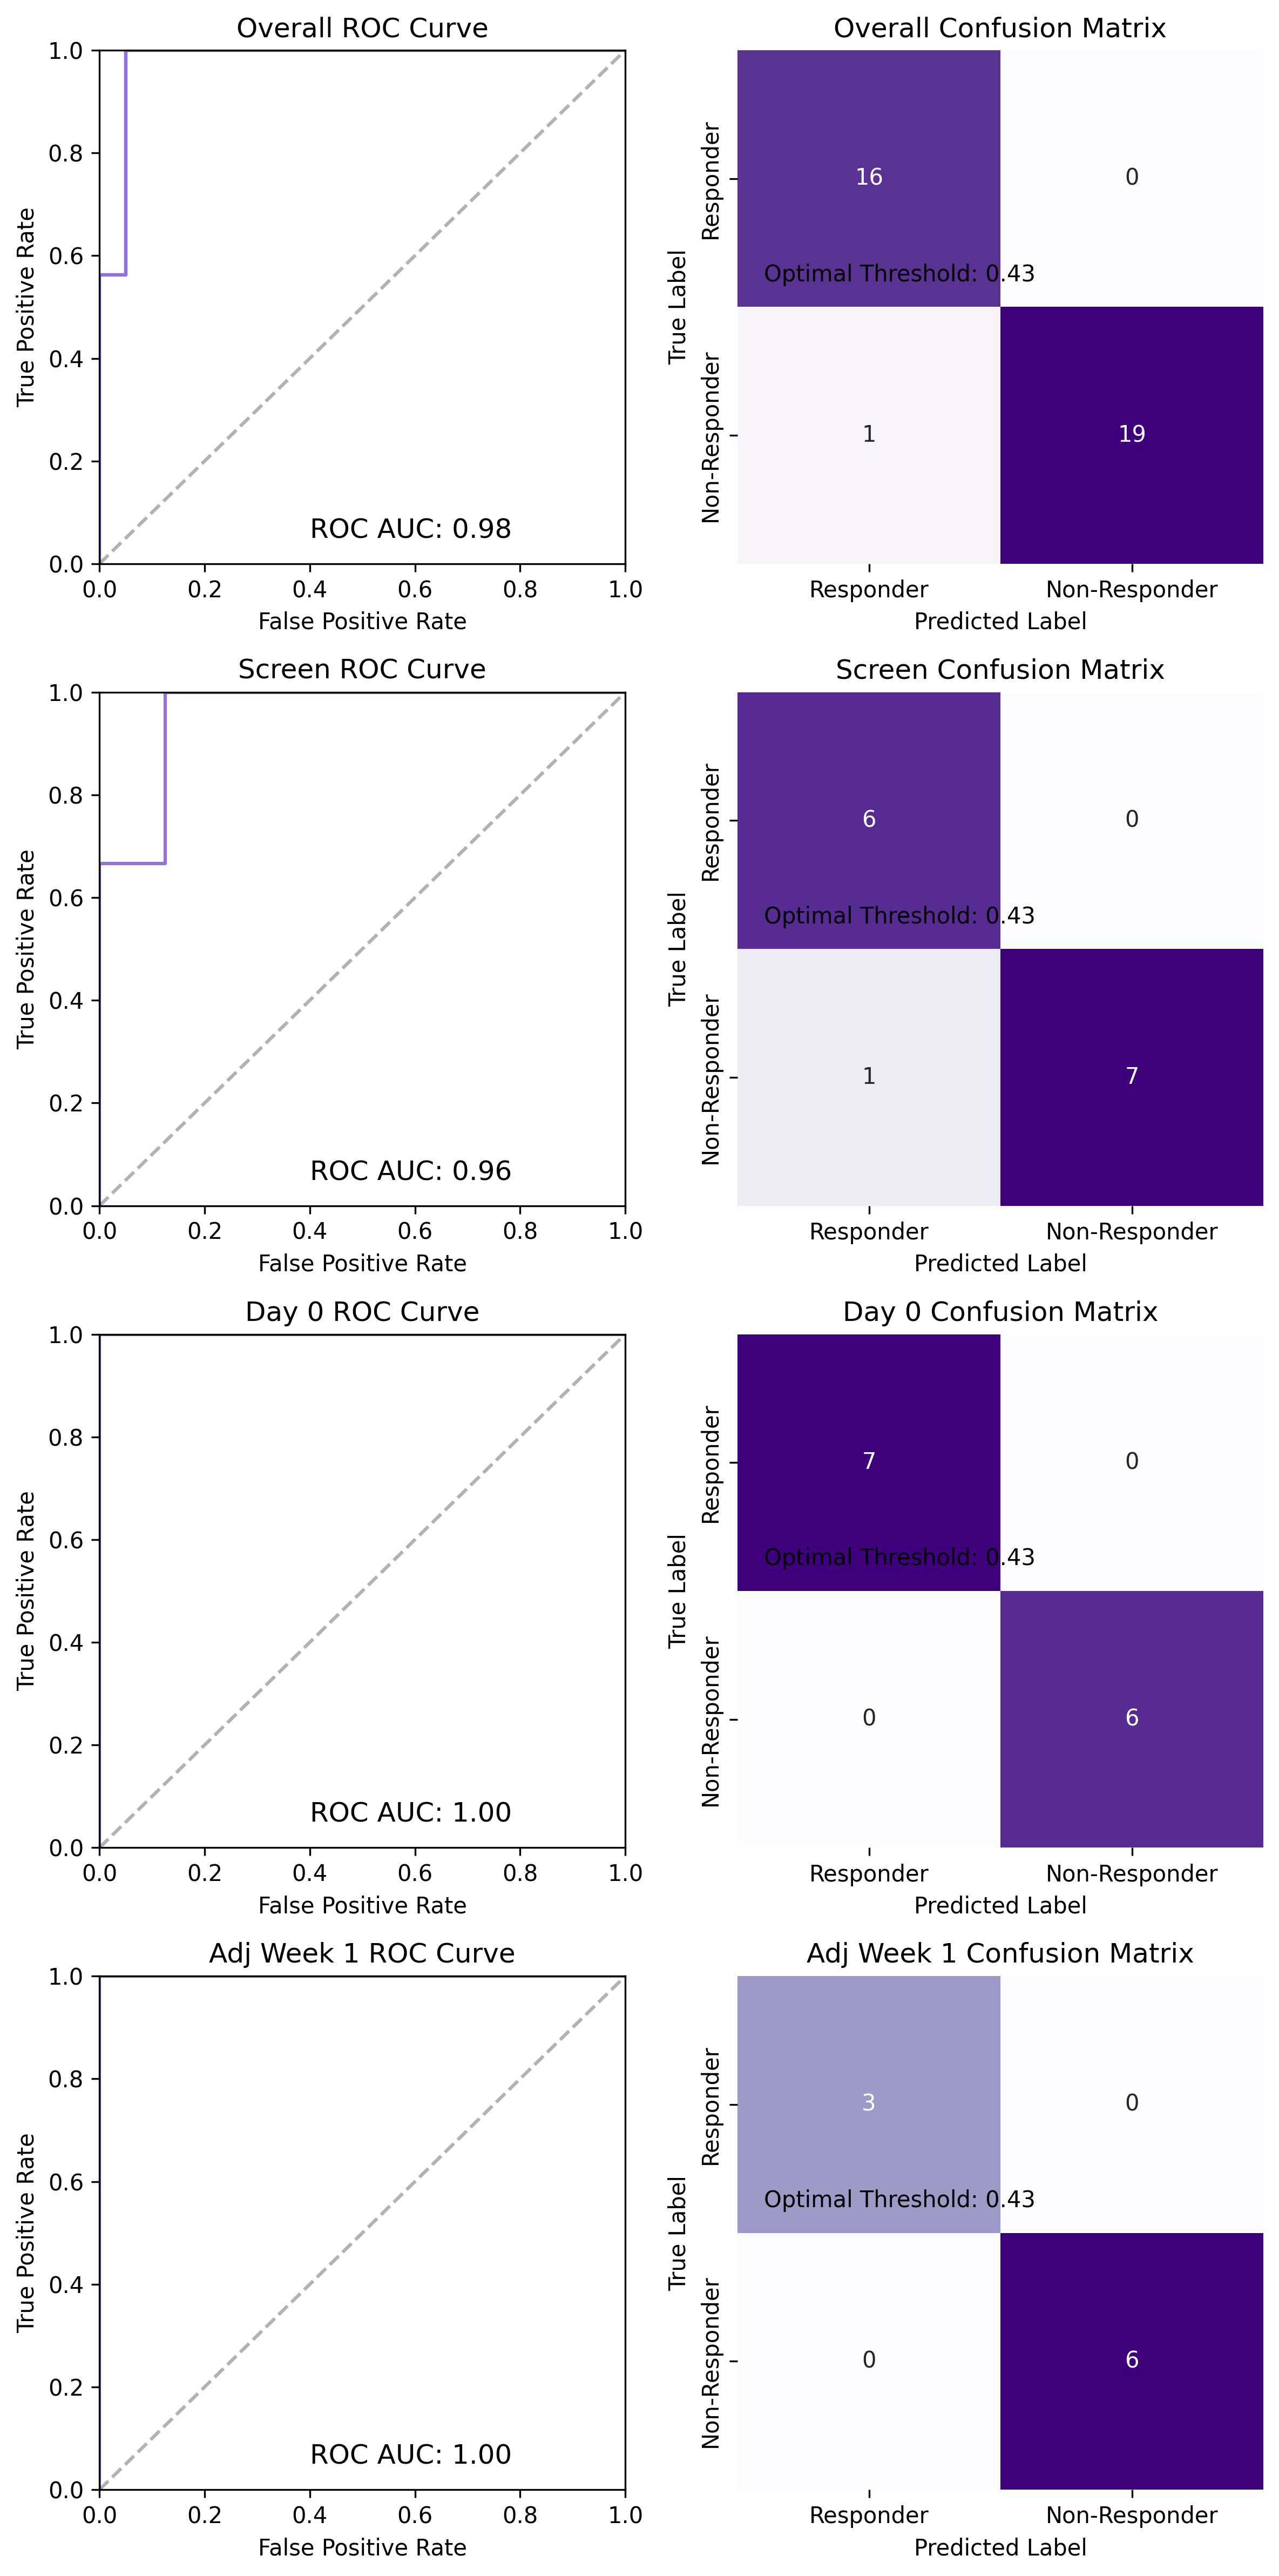

Best Overall Model: LogisticRegression(C=0.01)
Top Features: ['cov_data', 'delfi_data', 'mds_data', 'fraglen_data', 'cna_data']


In [8]:
model = LogisticRegression()
hyperparameter_dict = {
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1.0, 10.0],
    'solver': ['liblinear', 'lbfgs']
}
results, best_overall_model, top_features, preds_dictionary, all_data = cov.train_test_model(model, hyperparameter_dict, meta_train, meta_test, k=10)

In [9]:
pd.set_option('display.max_rows', None)

In [10]:
test_data = combined_data[combined_data.index.isin(test_ids)]
screen_data = cov.get_subset(cov.screen_ids, df=combined_data)
test_screen_data = cov.get_subset(cov.screen_ids, df=test_data)
day0_data = cov.get_subset(cov.day0_ids, df=combined_data)
test_day0_data = cov.get_subset(cov.day0_ids, df=test_data)
adjwk1_data = cov.get_subset(cov.adjwk1_ids, df=combined_data)
test_adjwk1_data = cov.get_subset(cov.adjwk1_ids, df=test_data)

In [11]:
def plot_confusion_matrix(data):
    y_labels = data['Treatment Response']
    y_pred_labels = data['Predicted Treatment Response']
    cm = confusion_matrix(y_labels, y_pred_labels, labels=['Responder', 'Non-Responder'])
    plt.figure(figsize=(4, 4), dpi=300)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False,
            xticklabels=['Responder', 'Non-Responder'],
            yticklabels=['Responder', 'Non-Responder'])
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

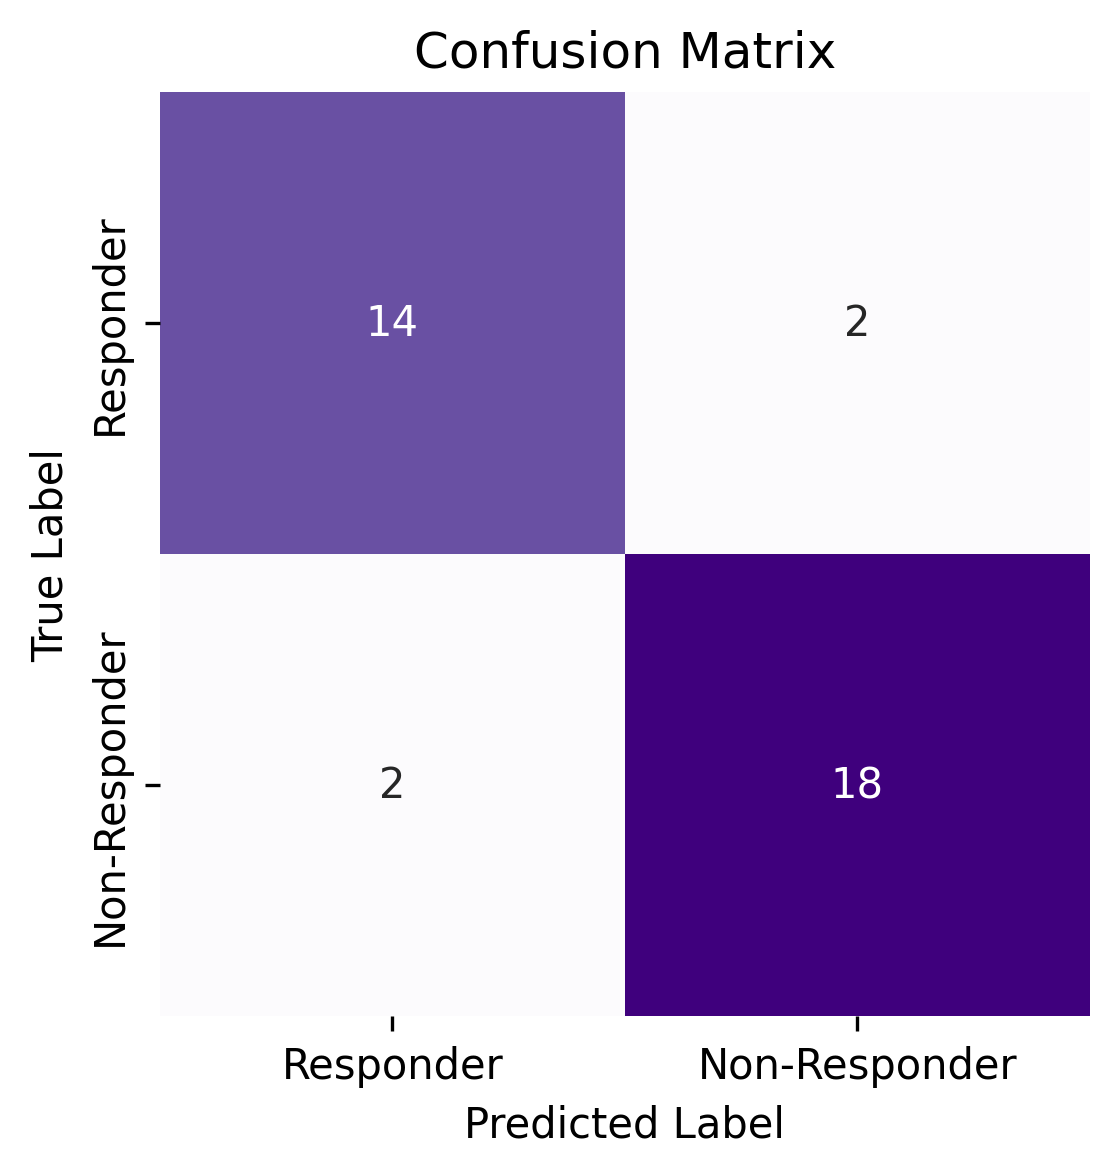

In [12]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(test_data)

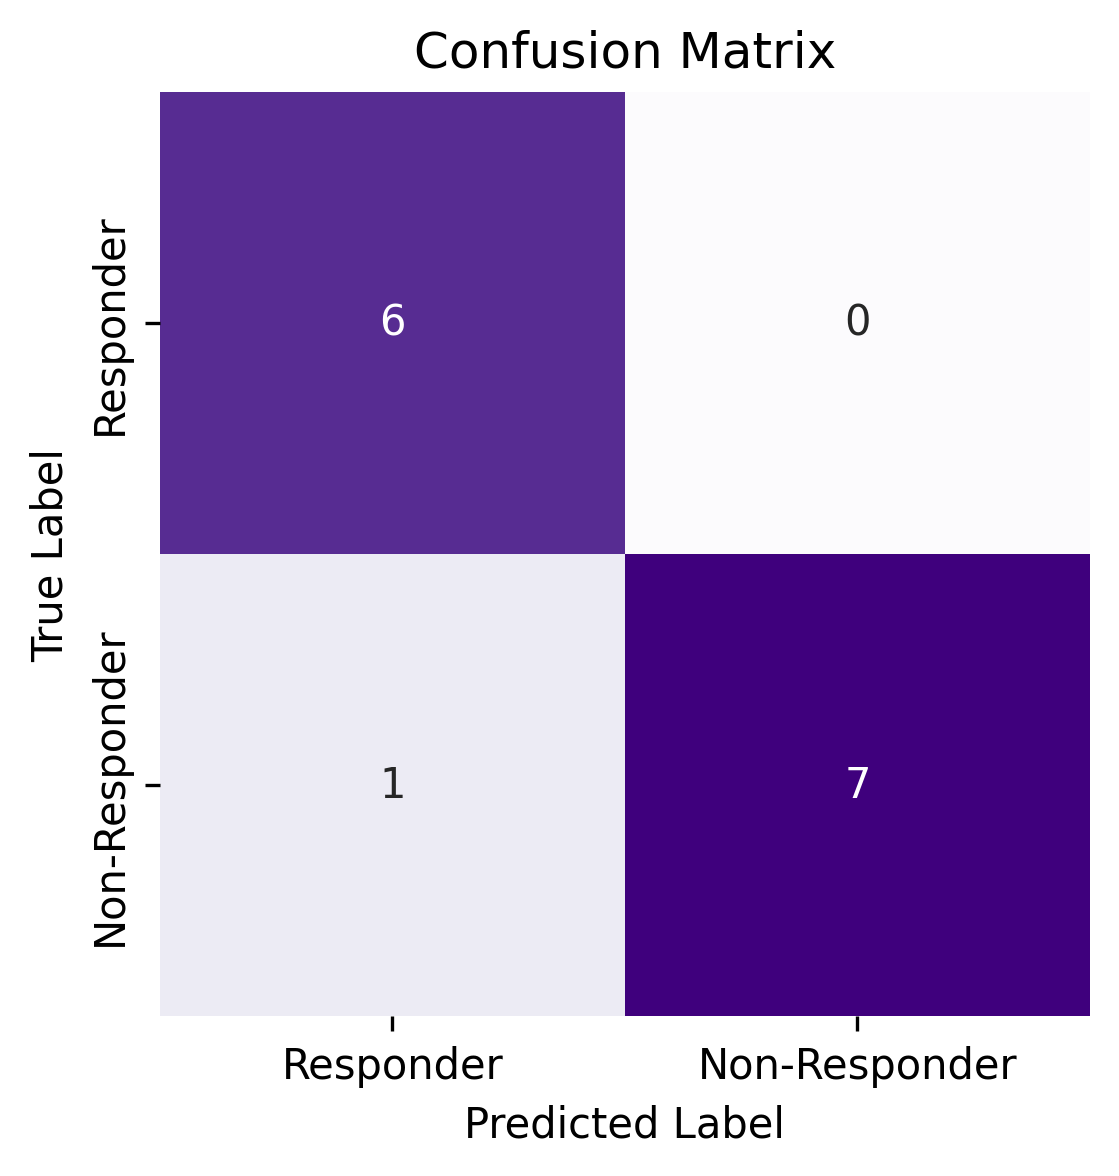

In [13]:
plot_confusion_matrix(test_screen_data)

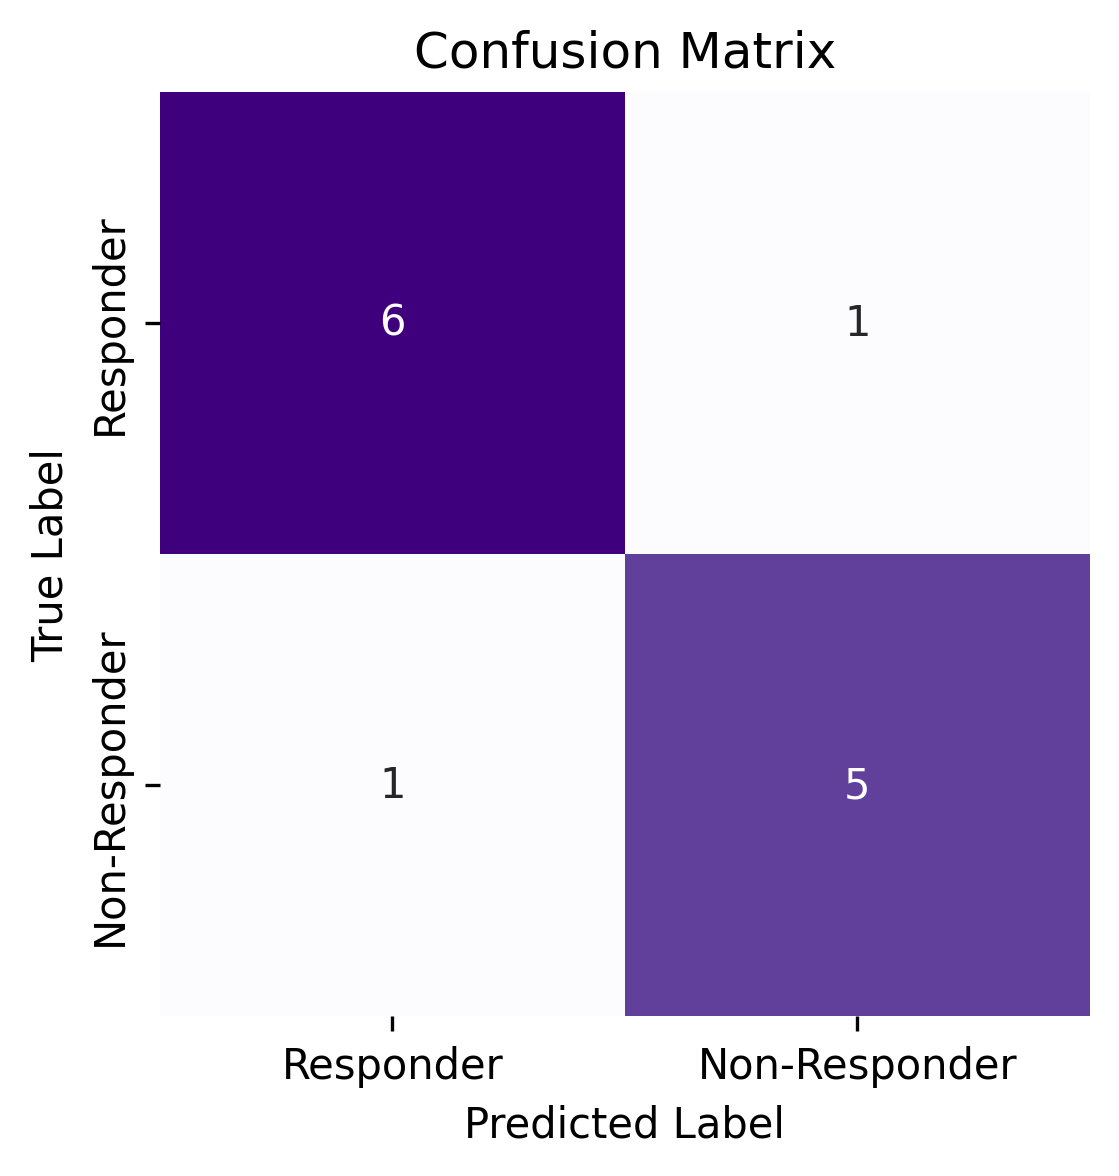

In [14]:
plot_confusion_matrix(test_day0_data)

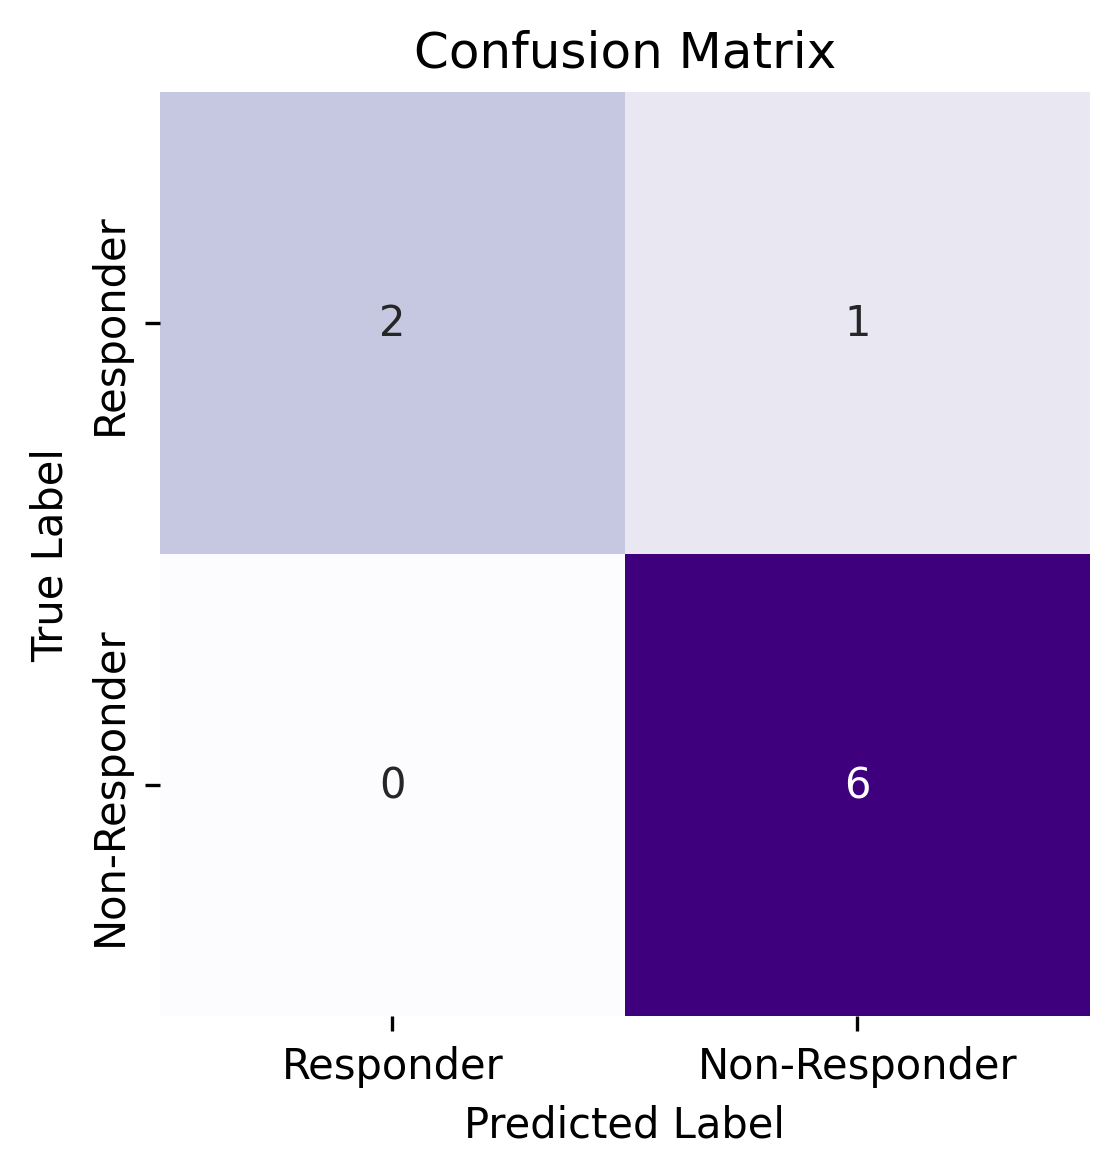

In [15]:
plot_confusion_matrix(test_adjwk1_data)

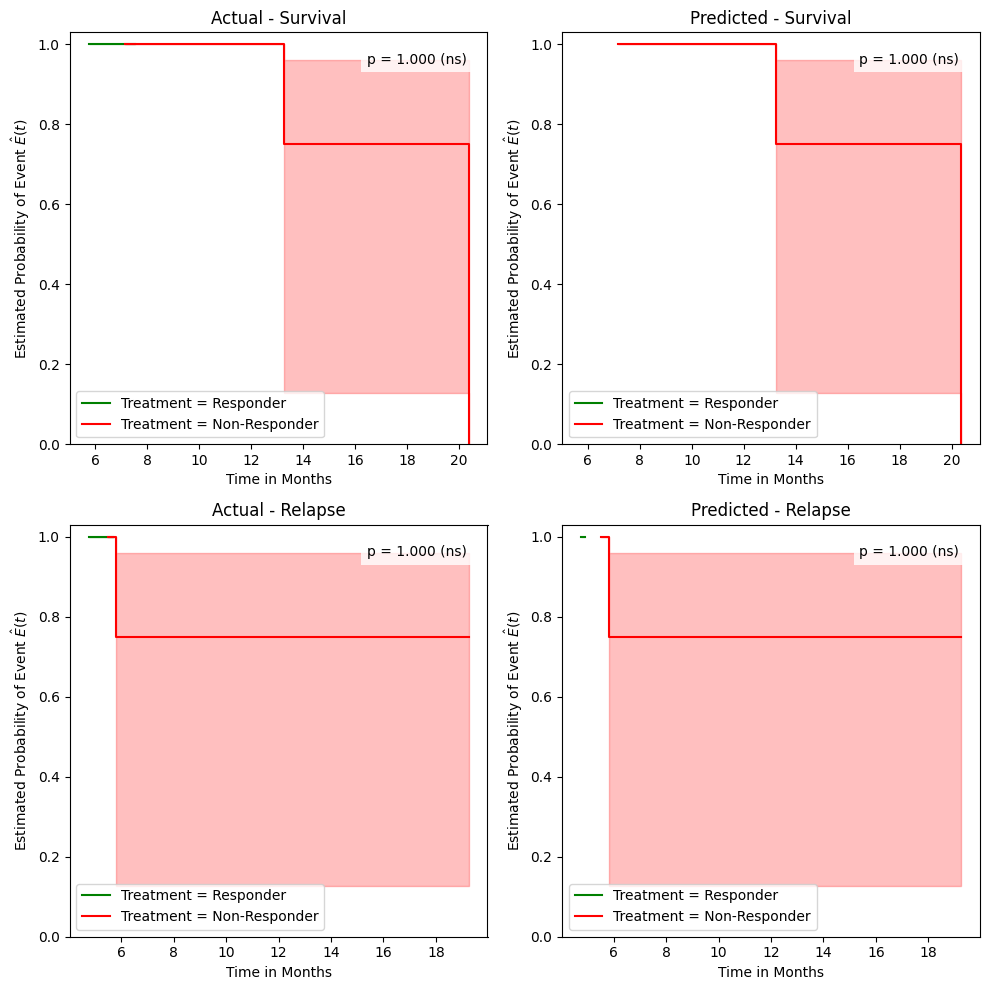

In [16]:
cov.survival_curve(test_adjwk1_data['Predicted Treatment Response'].to_dict())

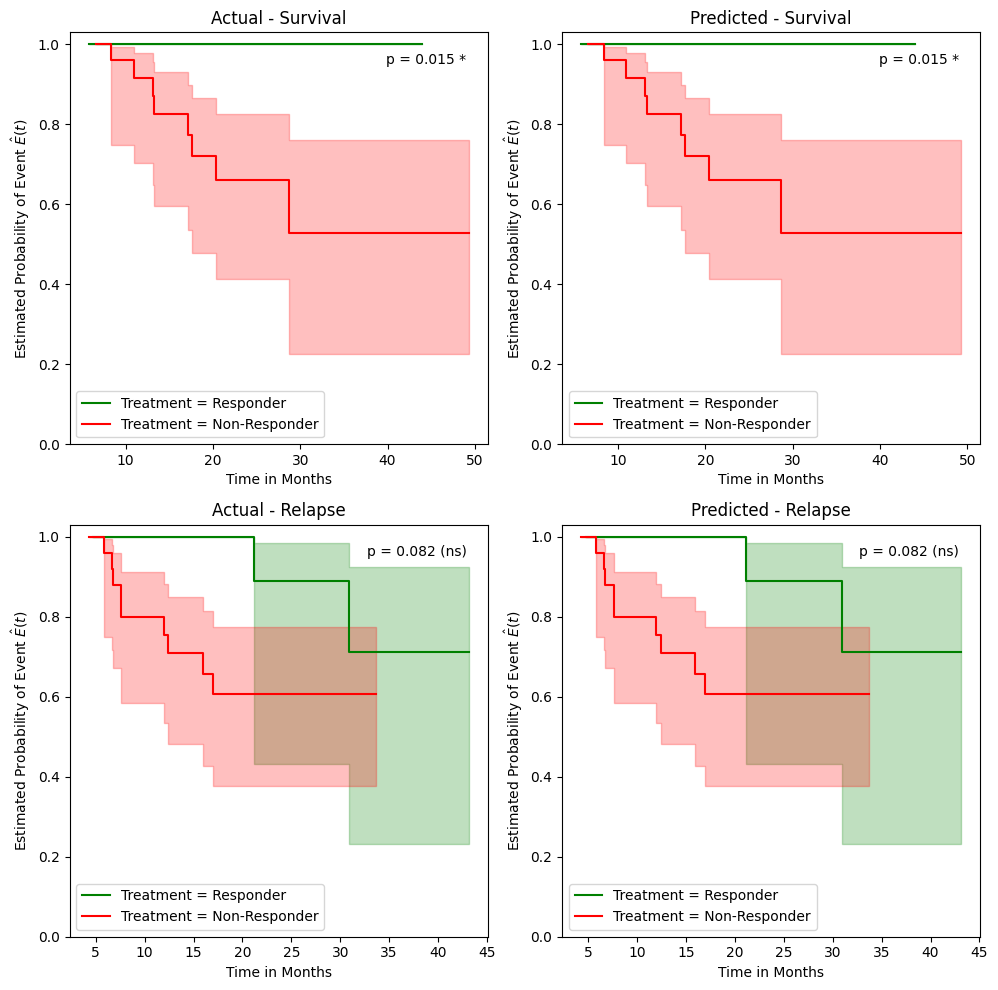

In [17]:
cov.survival_curve(adjwk1_data['Predicted Treatment Response'].to_dict())

In [43]:
train_data = combined_data[combined_data.index.isin(train_ids)]
test_data = combined_data[combined_data.index.isin(test_ids)]

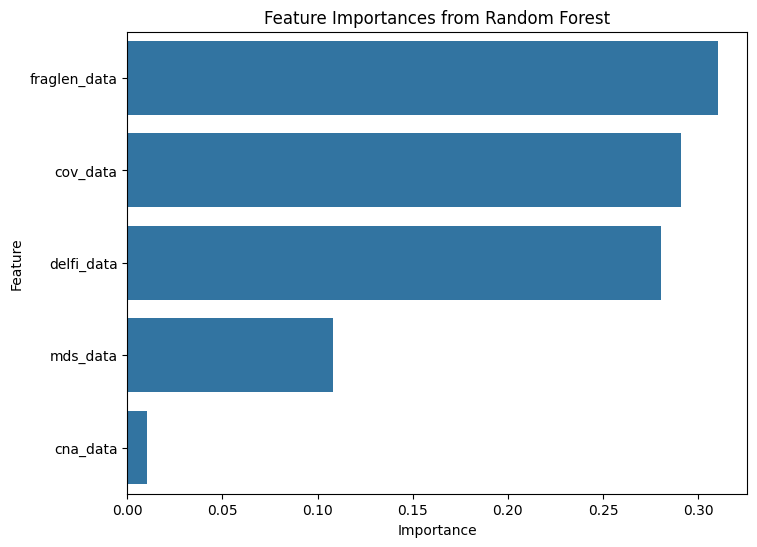

        Feature  Importance
3  fraglen_data    0.310317
0      cov_data    0.290771
1    delfi_data    0.280308
2      mds_data    0.108304
4      cna_data    0.010301


In [44]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Training data
data= train_data
# Create DataFrame
df = pd.DataFrame(data)

# Splitting data into features and target
X = df.drop('Treatment Response', axis=1)
y = df['Treatment Response']

# Train random forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances from Random Forest')
plt.show()

# Print feature importances
print(feature_importances)

# Ready to evaluate on test data when you provide it!


In [46]:
test_labels = test_data['Treatment Response']
test_data = test_data.drop('Treatment Response', axis=1)


# Predictions
predictions = rf.predict(test_data)
probs = rf.predict_proba(test_data)[:, 1]  # Probability for positive class (Responder)
plt.figure(figsize=(2,2), dpi=300)
# Classification report and confusion matrix
print(classification_report(test_labels, predictions))
cm = confusion_matrix(test_labels, predictions, labels=['Responder', 'Non-Responder'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False,  xticklabels=['Responder', 'Non-Responder'],
					yticklabels=['Responder', 'Non-Responder'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC curve
fpr, tpr, thresholds = roc_curve([1 if label == 'Responder' else 0 for label in test_labels], probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(2,2), dpi=300)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Ready to evaluate on more test data when you provide it!


KeyError: 'Treatment Response'

In [33]:
predictions

array(['Responder', 'Responder', 'Non-Responder', 'Non-Responder',
       'Non-Responder', 'Responder', 'Responder', 'Non-Responder',
       'Responder', 'Responder', 'Responder', 'Responder', 'Responder',
       'Responder', 'Non-Responder', 'Non-Responder', 'Non-Responder',
       'Non-Responder', 'Non-Responder', 'Responder', 'Non-Responder',
       'Non-Responder', 'Non-Responder', 'Non-Responder', 'Non-Responder',
       'Responder', 'Responder', 'Responder', 'Responder', 'Responder',
       'Responder', 'Non-Responder', 'Non-Responder', 'Non-Responder',
       'Non-Responder', 'Non-Responder'], dtype=object)